# Exercise 01; POS tagger sandbox

**Dejan Dukic**

**Matr #: 2984857**

### Obtaining the corpora

In [1]:
import nltk

In [2]:
nltk.download('brown')
nltk.download('treebank')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Dejan\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\Dejan\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Dejan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
from nltk.corpus import brown, treebank

[croatian corpus link]('https://github.com/ffnlp/sethr/blob/master/set.hr.conll'), necessary to download and have in the working directory

set up the conllCorpusReader for the particular corpus structure, explained [here](https://github.com/ffnlp/sethr); they are using [universal POS tags](http://universaldependencies.org/docs/u/pos/index.html), which will also be used for accuracy measurement later on

column syntax supported by the conllCorpusReader can be found [here](http://www.nltk.org/_modules/nltk/corpus/reader/conll.html)

In [4]:
root = %pwd
columnStructure = ('ignore', 'words', 'ignore', 'ignore', 'ignore', 'ignore', 'ignore', 'ignore', 'ignore', 'pos')
hrCorp = nltk.corpus.ConllCorpusReader(root, '.conll', columnStructure)

a preprocessing step is required in order to get word-POS tag pairs for each sentence

In [5]:
corpusConvert = [[(pair[0], pair[1].split('|')[0].split('=')[1]) for pair in sent] for sent in hrCorp.tagged_sents('set.hr.conll')]

In [6]:
corpusConvert[0]

[('Proces', 'NOUN'),
 ('privatizacije', 'NOUN'),
 ('na', 'ADP'),
 ('Kosovu', 'PROPN'),
 ('pod', 'ADP'),
 ('povećalom', 'NOUN')]

### Helper functions

the featureDetect function is meant for capturing syntactic characteristics within a given word of a sentence which should give hints about its part of speech membership. the features used here come from [this tutorial](https://nlpforhackers.io/training-pos-tagger/).

In [7]:
def featureDetect(sentence, index):
    """ 
    sentence: list of words, i.e. [w1, w2, ...], 
    index: the index of the word 
    """
    
    return {
        'word': sentence[index],
        'is_first': index == 0,
        'is_last': index == len(sentence) - 1,
        'is_capitalized': sentence[index][0].upper() == sentence[index][0],
        'is_all_caps': sentence[index].upper() == sentence[index],
        'is_all_lower': sentence[index].lower() == sentence[index],
        'prefix-1': sentence[index][0],
        'prefix-2': sentence[index][:2],
        'prefix-3': sentence[index][:3],
        'suffix-1': sentence[index][-1],
        'suffix-2': sentence[index][-2:],
        'suffix-3': sentence[index][-3:],
        'prev_word': '' if index == 0 else sentence[index - 1],
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1],
        'has_hyphen': '-' in sentence[index],
        'is_numeric': sentence[index].isdigit(),
        'capitals_inside': sentence[index][1:].lower() != sentence[index][1:]
    }

The untag function returns the list of words without tags from a tagged sentence; the transform_to_dataset function returns X and y representing the dictionary of detected features for each word from a given sentence and the list of correct corresponding tags respectively

In [8]:
def untag(tagged_sentence):
    return [w for w, t in tagged_sentence]

def transform_to_dataset(tagged_sentences):
    X, y = [], []
    for tagged in tagged_sentences:
        for index in range(len(tagged)):
            X.append(featureDetect(untag(tagged), index))
            y.append(tagged[index][1])     
 
    return X, y

### Splitting each corpus to train/test sets based on the 80/20 rule

In [9]:
X1 = treebank.tagged_sents()
X1_sents = treebank.sents()

X2 = brown.tagged_sents()
X2_sents = brown.sents()

X3 = list(corpusConvert)
X3_sents = hrCorp.sents('set.hr.conll')

In [10]:
splitX1 = int(.8 * len(X1))
splitX2 = int(.8 * len(X2))
splitX3 = int(.8 * len(X3))

size = 10000

X1_train, Y1_train = transform_to_dataset(X1[:splitX1])
X1_test, Y1_test = transform_to_dataset(X1[splitX1:])

X2_train, Y2_train = transform_to_dataset(X2[:splitX2])
X2_test, Y2_test = transform_to_dataset(X2[splitX2:])

X3_train, Y3_train = transform_to_dataset(X3[:splitX3])
X3_test, Y3_test = transform_to_dataset(X3[splitX3:])

In [11]:
print(len(X1_train), len(X1_test))

80637 20039


In [12]:
print(len(X2_train), len(X2_test))

979646 181546


In [13]:
print(len(X3_train), len(X3_test))

67046 16589


### Model 1

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
 
clf = Pipeline([
    ('vectorizer', DictVectorizer(sparse=False)),
    ('classifier', LogisticRegression())
])
 
clf.fit(X1_train[:size], Y1_train[:size])
 
print('Training completed')
acc1_x1 = clf.score(X1_test, Y1_test)

Training completed


### Model 2

In [15]:
nltkTag = nltk.pos_tag_sents(X1_sents[splitX1:])

flatten the ground trouth list, the predicted tags and compare

In [16]:
from itertools import chain
import numpy as np
acc2_x1 = np.mean(np.array([1 if a == b else 0 for a,b in zip([pair[1] for pair in chain.from_iterable(X1[splitX1:])], [pair[1] for pair in chain.from_iterable(nltkTag)])]))

### Model(s) 3

Rule-based POS taggers
DefaultTagger that simply tags everything with the same tag

RegexpTagger that applies tags according to a set of regular expressions

N-Gram (n-gram tagger is a generalization of a unigram tagger whose context is the current word together with the part-of-speech tags of the n-1 preceding token); variations: UnigramTagger, BigramTagger, TrigramTagger

In [17]:
from nltk import DefaultTagger as df
from nltk import UnigramTagger as ut
from nltk import BigramTagger as bt
from nltk import TrigramTagger as tg
from nltk import RegexpTagger as rt

patterns = [(r'.*ing$', 'VBG'), (r'.*ed$', 'VBD'), (r'.*es$', 'VBZ'), (r'.*ould$', 'MD'), (r'.*\'s$', 'NN$'),               
             (r'.*s$', 'NNS'), (r'^-?[0-9]+(.[0-9]+)?$', 'CD'), (r'.*', 'NN')]

model3_def = df('NN')
model3_uni = ut(X1[:splitX1])
model3_bi = bt(X1[:splitX1])
model3_tri = tg(X1[:splitX1])
model3_regex = rt(patterns)

In [18]:
acc31_x1 = model3_def.evaluate(X1[splitX1:])
acc32_x1 = model3_uni.evaluate(X1[splitX1:])
acc33_x1 = model3_bi.evaluate(X1[splitX1:])
acc34_x1 = model3_tri.evaluate(X1[splitX1:])
acc35_x1 = model3_regex.evaluate(X1[splitX1:])

Performance of model 1 trained on X1 when applied to X2

In [19]:
acc1_x2 = clf.score(X2_test, Y2_test)

Retraining model 1 on X2 and then testing on X2

In [20]:
clf.fit(X2_train[:size], Y2_train[:size])
acc1_x2_2 = clf.score(X2_test, Y2_test)

Nlkt pretrained on X2

In [21]:
nltkTag2 = nltk.pos_tag_sents(X2_sents[splitX2:])

In [22]:
acc2_x2 = np.mean(np.array([1 if a == b else 0 for a,b in zip([pair[1] for pair in chain.from_iterable(X2[splitX2:])], [pair[1] for pair in chain.from_iterable(nltkTag2)])]))

Rule-based taggers retrained and tested on X2

In [23]:
model3_def = df('NN')
model3_uni_2 = ut(X2[:splitX2])
model3_bi_2 = bt(X2[:splitX2])
model3_tri_2 = tg(X2[:splitX2])
model3_regex_2 = rt(patterns)

In [24]:
acc31_x2 = model3_def.evaluate(X2[splitX2:])
acc32_x2 = model3_uni_2.evaluate(X2[splitX2:])
acc33_x2 = model3_bi_2.evaluate(X2[splitX2:])
acc34_x2 = model3_tri_2.evaluate(X2[splitX2:])
acc35_x2 = model3_regex_2.evaluate(X2[splitX2:])

### Visualizing the accuracies of different models

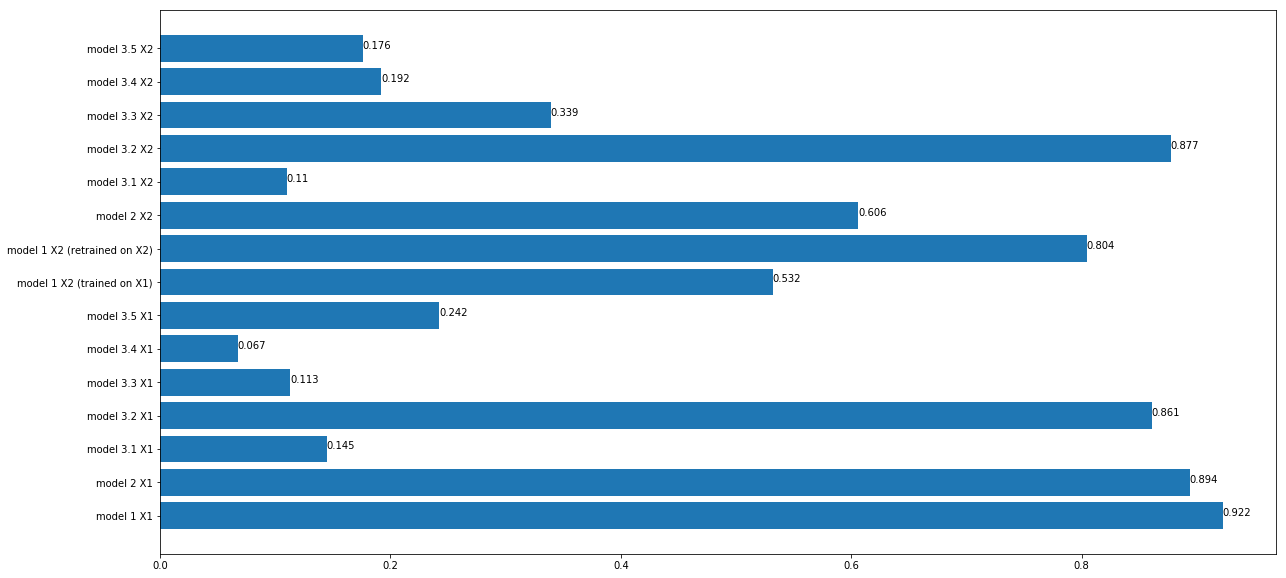

In [25]:
import matplotlib.pyplot as plt

data1 = [acc1_x1, acc2_x1, acc31_x1, acc32_x1, acc33_x1, acc34_x1, acc35_x1, acc1_x2, acc1_x2_2, acc2_x2, 
               acc31_x2, acc32_x2, acc33_x2, acc34_x2, acc35_x2]

labels = [each.strip() for each in 'model 1 X1, model 2 X1, model 3.1 X1, model 3.2 X1, model 3.3 X1, model 3.4 X1, model 3.5 X1, model 1 X2 (trained on X1), model 1 X2 (retrained on X2), model 2 X2, model 3.1 X2, model 3.2 X2, model 3.3 X2, model 3.4 X2, model 3.5 X2'.split(',')]

fig, ax = plt.subplots(figsize=(20, 10))

plot1 = ax.barh(range(len(data1)), data1)
ax.set_yticks(range(len(data1)))
ax.set_yticklabels(labels)

for i, v in enumerate(data1):
    ax.text(v, i, str(round(v, 3)))

plt.show()

### Task 2

the pSCRDRtagger needs to be present in the working directory (all of this will be pushed to git anway but im mentioning just in case)

needed to hack the RDR tagger to circumvent the fact that RDR is written for Python 2; only the scripts in this folder will work with this notebook

### Model 4

wont change a thing from the feature extraction to see how well it fares on a completely different language

lets train on the whole corpus

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
 
clf = Pipeline([
    ('vectorizer', DictVectorizer(sparse=False)),
    ('classifier', LogisticRegression())
])
 
# clf.fit(X3_train[:size], Y3_train[:size])
clf.fit(X3_train, Y3_train)
 
print('Training completed')
acc4_x3 = clf.score(X3_test, Y3_test)

Training completed


In [27]:
print(acc4_x3)

0.963228645488


### Model 5

In [28]:
from pSCRDRtagger.RDRPOSTagger import RDRPOSTagger

In [29]:
preTrainedRDR = RDRPOSTagger()

In [30]:
try:
    preTrainedRDR.constructSCRDRtreeFromRDRfile(r'hr-upos.RDR')
except NameError:
    xrange = range
    preTrainedRDR.constructSCRDRtreeFromRDRfile(r'hr-upos.RDR')

In [31]:
from pSCRDRtagger.Utils import readDictionary

In [32]:
DICT = readDictionary(r'hr-upos.DICT')

lets get tagging finally

In [33]:
#prediction based on the pretrained RDR POS tagger on a Croatian language corpus
#the RDR is unstable and has sporadic errors in some sentences which seem perfectly normal to me; I will exclude those from 
#testing the performance of both models

totalPredictedTags = list()
errorSentences = list()
for i, sent in enumerate(X3_sents[splitX3:]):
    try:
        tempTaggedSent = preTrainedRDR.tagRawSentence(DICT, ' '.join([str(word) for word in sent]))
    except:
        errorSentences.append(i)
        continue
    tags = [pair.split('/')[1] for pair in tempTaggedSent.split(' ')]
    totalPredictedTags.extend(tags)

print(len(errorSentences))
print(len(X3_sents[splitX3:]))
#its not too bad

167
752


compare to true tags

In [34]:
from itertools import chain
import numpy as np

sentencesToBeCompared = [sent for i, sent in enumerate(X3[splitX3:]) if i not in errorSentences]
tagsTrue = [tag for word, tag in chain.from_iterable(sentencesToBeCompared)]

acc5_x3 = np.mean(np.array([1 if predicted == true else 0 for predicted,true in zip(totalPredictedTags, tagsTrue)]))

### Visualize

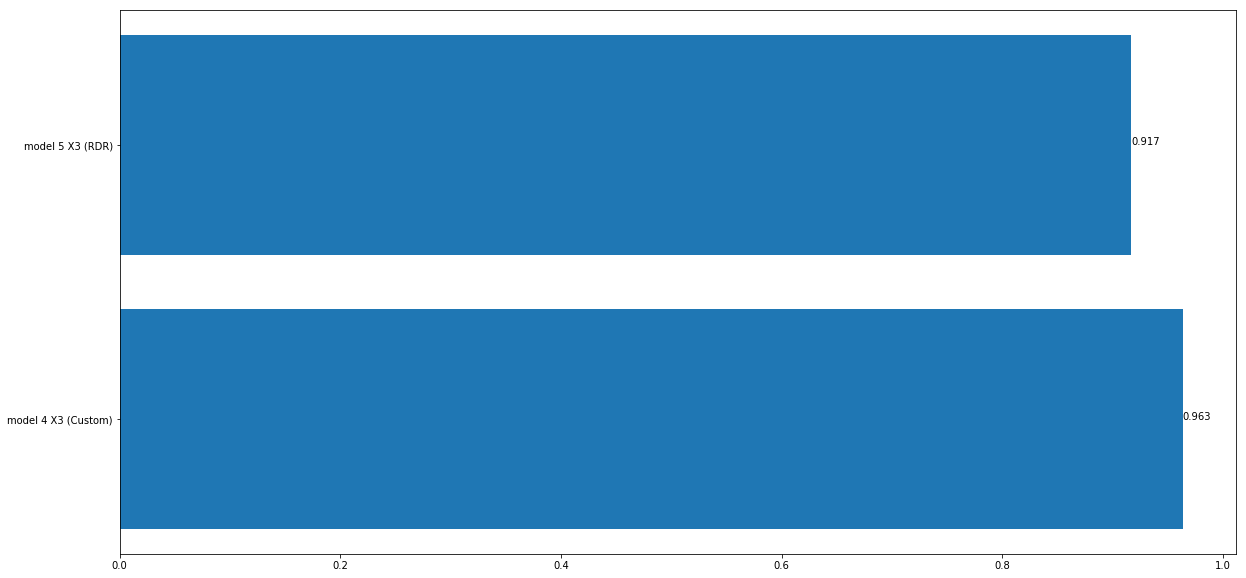

In [35]:
import matplotlib.pyplot as plt

data2 = [acc4_x3, acc5_x3]

labels = [each.strip() for each in 'model 4 X3 (Custom), model 5 X3 (RDR)'.split(',')]

fig, ax = plt.subplots(figsize=(20, 10))

plot1 = ax.barh(range(len(data2)), data2)
ax.set_yticks(range(len(data2)))
ax.set_yticklabels(labels)

for i, v in enumerate(data2):
    ax.text(v, i, str(round(v, 3)))

plt.show()